+++ 
date = "2018-12-27"
title = "Classical Speech Enhancement Techniques"
markup = "mmark"
+++

# Classical Speech Enhancement Part 1: Spectral subtraction

This is part 1 in a series of three posts that implement three classical DSP methods of enhancing speech in audio recordings. It uses slides and re-implements code from a source separation tutorial that can be found [here](https://ccrma.stanford.edu/~njb/teaching/sstutorial/). The three methods are spectral subtraction, Wiener filtering and probabilistic estimation (Ephraim-Malah). 

## The general framework

The speech enhancement problem is posed as a source separation problem -- given a mixture of noise ($d[n]$) and signal ($x[n]$), separate the two. We model the given audio in the frequency space as: $Y(\omega) = X(\omega) + D(\omega)$

To convert the original audio sequence $y[n]$ into $Y(\omega)$, we first convert it into a sequence of overlapping frames. Each frame indexed by $m$ has $M$ samples and an overlap determined by $R$ eg. if $R = M/2$, we have 50% overlap. We take each frame's fourier transform (FFT) to get $Y_{m}(\omega)$. Then our goal is to estimate $X_{m}(\omega)$ as $\hat{X}_{m}(\omega)$. We can reconstruct the desired audio $\hat{x}[n]$ using  an inverse FFT and overlap-add.

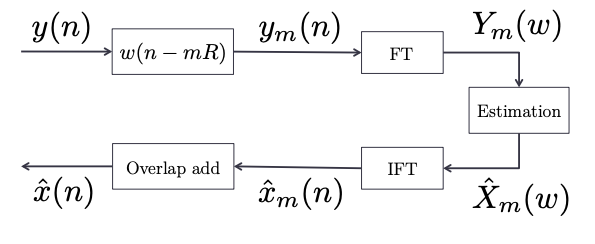

The challenge is to (step 1) model our noise $D(\omega)$ and (step 2) estimate $X(\omega)$ i.e $\hat{X}(\omega)$. 

One approach to modeling the noise is by making the assumption that noise is slowly varying compared to speech. Using a voice activity detector, we can tell what frames do not have speech, and estimate $D(\omega)$ from those frames (eg. by averaging). We will look at one example of estimating the noise in the next section.

The general algorithm for producing the magnitude of the signal estimate $|\hat{X}(\omega)|$ can be reduced to designing a gain curve $H_{m}(\omega) = |\hat{X}_{m}(\omega)|/|Y_{m}(\omega)|$. i.e for each $m$th audio frame $Y_{m}(\omega)$, we derive the estimate $|\hat{X}_{m}(\omega)|$ by multiplying by a gain curve: $|\hat{X}_{m}(\omega)| = |H_{m}(\omega)| |Y_{m}(\omega)|$. The gain curve $H_{m}(\omega)$ determines the scaling factors (or gains) for each spectral component $\omega$. The three different methods, as we'll see soon, provide different gain curves depending on different assumptions which lead to varying subjective results in speech enhancement.

## Step 1) Noise estimation

Given the noisy signal alone, how do we extract the properties of the noise? Specifically, how do we estimate the noise power spectrum?

Our goal is to estimate the noise magnitude $|D_{m}(\omega)|$ given only $|Y_{m}(\omega)|$. We can model the noise spectrum as slowly varying compared to the speech spectrum. With this assumption, one simple approach to noise estimation is performing a running mean on the input signal $|Y(\omega)|$. 

The running mean computation is best described as a low-pass filter - it only allows the slowly varying (low frequency) components to pass through. The parameter of concern for the running mean is the time duration over which to compute the running mean i.e the time window $\tau$ corresponding to $N$ samples.

The simplest running mean implementation (also called low-pass filter or moving average) is perhaps the box-car filter or simple moving average (SMA). At each timestep, it computes the mean over the last $N$ signal samples; this requires storing $N$ in a FIFO (first in first out) buffer which can be very memory intensive for large values of $N$. The output of the box-car filter depends only on the past N input signal samples. It is an example of an FIR (finite impulse response) filter; the impulse response of the filter has a finite length $N$. 

A less memory intensive but equally effective running mean filter is the exponential moving average (EMA) or a single-pole IIR (infinite impulse response) filter. The EMA filter uses recursion -- the output of the filter depends on the previous output and the current input sample. This allows the filter to express a frequency response similar to the SMA but requiring a FIFO buffer of size 1. The output of the filter is given by the equation

$$ y[n] = (1 - \alpha) x[n] + \alpha y[n-1] $$

$\alpha$ is the parameter that determines the running mean window length $\tau$. In the box-car filter $T$ was defined as the number of samples contained in T seconds. For the IIR filter we define $T$ as the time for the output of the filter to reach 63.5% of the input step signal. $\alpha = \exp^{-\Delta T / \tau}$ where $\Delta T$ is the sampling interval.

The frequency response of the SMA and EMA is presented below for comparison:

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fs = 200 # sample rate in Hz
tau = 10 # time window in seconds for mean computation

# Boxcar/SMA filter params
N = int(tau*fs) # Number of samples corresponding to tau
h_boxcar = np.ones(N)/N  # impulse response of boxcar filter

# EMA filter params
alpha = np.exp(-1/(fs*tau))
a_ema = [1, -alpha] # Denominator
b_ema =  1 - alpha # Numerator

w, h = signal.freqz(h_boxcar)
plt.plot(w, 20 * np.log10(abs(h)), 'b')

w, h = signal.freqz(b_ema, a_ema)
plt.plot(w, 20 * np.log10(abs(h)), 'r')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.ylim(-100, 5);
plt.legend(['SMA', 'EMA']);
plt.title('SMA and EMA filters with parameters leading to similar frequency response');

Thus by choosing an appropriate value for $\alpha$, we can estimate the noise spectrum as the output of the EMA. Note that we have as many scalar EMA filters as there are $\omega$s. 

This approach doesn't make a distinction between frames containing speech and those that don't i.e the noise estimate includes pieces of the speech signal as well. We could use a voice activity detector to only update the EMA filter output for non-speech frames. 

Another approach described in "Adaptive noise estimation algorithm for speech enhancement" does something to that effect. It makes $\alpha$ for each frame $m$ in the EMA equation a sigmoidal function of the a-posteriori SNR: $\alpha(m) = 1/(1+\exp^{-a (SNR(m) - T)})$. The SNR is estimated by $|Y_m(\omega)|^{2}/E[D_{m-1}(\omega)]$ where $E[D_{m-1}(\omega)]$ is the average of the noise estimates of the previous 5-10 frames. The SNR is called a-posteriori because it is a ratio of the signal+noise power to noise power (as opposed to a-priori which is signal power to noise power). 

![image.png](img/alpha_snr_noise_estimation.png)

The SNR estimation can be interpreted as measuring how much noise there is in each frame. When SNR is close to 1, the frame contains noise only and for values greater than 1, the frame contains speech+noise. Specfically, if at frame $m$ the $|Y_m(\omega)|^2 \to E[D_{m-1}(\omega)]$ i.e the spectrum is similar to the noise spectrum, SNR is close to 1 and $\alpha(m) \to 0$; the noise estimate is closer to the current frame's spectrum (there is a larger weighting to the current frame). 

## Step 2) Estimating the signal

What we get from step 1 is for every frame $m$ an estimate of the average value of the noise spectrum $E[D_{m}(\omega)]$ for each frequency bin $\omega$. How do we use it to estimate the signal?

### Magnitude spectral subtraction

The simplest approach is to subtract the input signal from the noise estimate to get the signal estimate $\hat{X}(\omega)$. Since the magnitude of $\hat{X}(\omega)$ needs to be non-negative, we rectify the difference using the max operator. The phase of the estimate is retained as the same as the input signal $Y(\omega)$.  

![image.png](img/mag_spectral_subtraction.png)

## Power spectral subtraction

The power spectral subtraction is a generalization of magnitude spectral subtraction where we take the $\alpha$th power for each of the magnitude terms.

![image.png](img/power_spectral_subtraction.png)

Re-formulating the above formula to put it in the Gain curve setup, we get 

![image.png](img/gain_spectral_subtraction.png)

![image.png](img/gain_curve_spectral_subtraction.png)

With both steps in place, let's put them together on real audio samples.

In [37]:
""" Begin with utility functions to convert the given audio into a list of audio-frames and back"""
import segmentaxis
from scipy.io import wavfile
import tqdm

def audio_to_frames(y: np.array, m=128, overlap=0.5) -> np.array:
    """Convert y[n] into a matrix of frames Y_m(w)"""
    # Create output array
    out = segmentaxis.segment_axis(y, m, int(overlap*m), end='pad')
    
    # Windowing allows the edges of each frame to taper down to zero reducing spectral leakage
    # Design a hanning window with proper scaling to make the window unit-norm
    win = np.hanning(m)
    win = win / np.sqrt(np.linalg.norm(win))
    out = out * win # Apply the window to each row/frame/chunk
    return out

def frames_to_audio(Y: np.array, m=128, overlap=0.5) -> np.array:
    """Convert Y_m(w) matrix of frames into a 1D signal y[n] using Overlap-Add"""
    one_d_arr = np.zeros((int(Y.size*overlap)+m, ))
    overlap_m = int(overlap*m)
    for i in range(Y.shape[0]):
        one_d_arr[i*overlap_m:(i*overlap_m)+m] += Y[i]
    return one_d_arr

In [3]:
""" Generate the noisy speech signal from a clean speech signal by adding noise"""
speech_file = "wav/input/female2.wav"
noise_file = "wav/input/noise_white.wav"

fs, x = wavfile.read(speech_file)
fs_noise, n = wavfile.read(noise_file)

# Scale the 16-bit wav files to floats between -1 and 1
# x = x/2**15
# n = n/2**15

noise_gain = 0.7
n = noise_gain * n[:len(x)]

y = x + n

In [5]:
"""Convert the signal into overlapping frames and take FFT"""
win_t = 0.03;                   # window size in seconds
win_s = round(fs*win_t);        # window size in samples

y_windowed = audio_to_frames(y, win_s)
Y = np.fft.fft(y_windowed)

In [48]:
"""Implement the adaptive noise estimation algorithm for speech enhancement (Step 1)"""

def noise_estimation_snr(Y: np.array):
    """Estimates the magnitude and power spectrum of the noise"""
    
    # Prepare the output variables
    est_Mn = np.zeros(Y.shape)
    est_Pn = np.zeros(Y.shape)
    
    N = 10 # Number of frames to use for estimating a-posteriori SNR
    
    # Iterate through each frame and estimate noise
    for m in range(Y.shape[0]):
        if m < N:
            # Use noisy spectra for first 10 iterations
            est_Mn[m] = abs(Y[m])
            est_Pn[m] = est_Mn[m] ** 2
        else:
            a = 15
            # A-posteriori SNR            
            gammak = (abs(Y[m])**2)/np.mean(abs(Y[m-N:m])**2, axis=0) 
            alpha = 1/(1+np.exp(-a*(gammak-1.5)))
            est_Mn[m] = alpha * abs(est_Mn[m-1]) + (1-alpha) * abs(Y[m])
            est_Pn[m] = alpha * (abs(est_Mn[m-1])**2) + (1-alpha) * (abs(Y[m])**2)
            
    return est_Mn, est_Pn
        
est_Mn, est_Pn = noise_estimation_snr(Y)

In [49]:
"""Estimate the clean signal from the noisy signal and estimate of the noise magnitude"""
def spec_subtract_mag(Y, est_Mn):
    est_magX = abs(Y) - est_Mn
    est_magX[est_magX < 0] = 1e-10 # Rectify the signal; the max operator
    est_phaseX = np.angle(Y)
    est_Sx = est_magX * np.exp(1j*est_phaseX)
    return est_Sx

def spec_subtract_pow(Y, est_Pn):
    est_powX = abs(Y)**2 - est_Pn
    est_powX[est_powX < 0] = 1e-10 # Rectify the signal; the max operator
    est_phaseX = np.angle(Y)
    est_Sx = est_powX * np.exp(1j*est_phaseX)
    return est_Sx

est_Sx_mag = spec_subtract_mag(Y, est_Mn)
est_Sx_pow = spec_subtract_pow(Y, est_Pn)

In [60]:
from IPython.display import Audio
import IPython.display

# Noisy audio
print("Noisy audio")
IPython.display.display(Audio(y, rate=fs))

# Estimate based on magnitude spectral subtraction
x_hat_framed = np.real(np.fft.ifft(est_Sx_mag))
x_hat = frames_to_audio(x_hat_framed, win_s)
print("Estimate based on magnitude spectral subtraction")
IPython.display.display(Audio(x_hat, rate=fs))

# Estimate based on power spectral subtraction
x_hat_framed = np.real(np.fft.ifft(est_Sx_pow))
x_hat = frames_to_audio(x_hat_framed, win_s)
print("Estimate based on power spectral subtraction")
IPython.display.display(Audio(x_hat, rate=fs))

Noisy audio


Estimate based on magnitude spectral subtraction


Estimate based on power spectral subtraction
